
# GHZ coherence under phase noise



## Introduction

This notebook studies **memoryless (Markovian) pure dephasing** on an $N$-qubit **GHZ** state. I quantify coherence drop of **GHZ** state using **fidelity** and **logarithmic negativity**.

### Why GHZ and dephasing?
- GHZ states, $\lvert \mathrm{GHZ}_N\rangle=\big(\lvert 0^{\otimes N}\rangle+\lvert 1^{\otimes N}\rangle\big)/\sqrt{2}$, are maximally sensitive to **phase noise** because their coherence is carried entirely by the off-diagonal element $\lvert 0^N\rangle\!\langle 1^N\rvert$.
- **Markovian dephasing** models fast, memoryless $Z$-type fluctuations. In this regime, **dynamic decoupling** (e.g., $Z$ echoes) does not help, which provides a clean baseline.



### What I do here
- Build circuits that prepare GHZ and accrue dephasing through explicit waits.
- Compute **analytic** $F(d)$ and **simulate** $F(d)$; overlay to validate modeling.
- Plot **logarithmic negativity** vs. depth for $n\in\{3,4,5\}$.
- Provide minimal, reproducible code so parameters $(n,\lambda,r,d)$ can be swept easily.

**Assumptions & scope.** Noise acts **only** during waits (no gate-time on $H/\mathrm{CX}$), is **Markovian** and **independent** across qubits and hits. Time-based $T_2$, amplitude damping, gate noise, and correlated/non-Markovian effects are out of scope here but can be added to test deviations from the analytic baseline.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity, partial_trace
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, phase_damping_error

In [2]:
# This function creates the noise model. A single-qubit phase-damping error is attached to identity.

def make_phase_noise_model(p_phase: float) -> NoiseModel:
    """
    Phase-damping noise model.

    Inputs
    p_phase : float in [0,1]
        Phase-damping probability per single-qubit gate application.

    Output
    noise_model : NoiseModel
        1q phase damping on selected 1q gates (including 'id'),
    """
    if not (0 <= p_phase <= 1):
        raise ValueError("p_phase must be in [0,1].")

    oneq = ['id'] 
    

    nm = NoiseModel()
    err_1q = phase_damping_error(p_phase)
    nm.add_all_qubit_quantum_error(err_1q, oneq)

   
    return nm


## GHZ with idle layers

I prepare GHZ, then add (depth − 1) idle layers. Each idle layer applies id to every qubit and then a barrier to stop optimizations that would remove the identities.


In [3]:
# This circuit prepares GHZ once and then appends identity gates per layer. 
# The barrier after each idle layer tells the transpiler not to remove those identities, so the noise model can act at each layer.
def ghz_with_idle_layers(n: int, depth: int) -> QuantumCircuit:
    """
    Prepare GHZ once, then add (depth-1) idle layers that accrue noise.
    Uses id + barrier so the transpiler keeps the idle gates.
    """
    if n < 2: raise ValueError("n must be >= 2")
    if depth < 1: raise ValueError("depth must be >= 1")

    qc = QuantumCircuit(n)
    # GHZ once
    qc.h(0)
    for j in range(n-1):
        qc.cx(j, j+1)

    # Idle layers
    for _ in range(depth-1):
        for q in range(n):
            qc.id(q)           # where 1q noise attaches
        qc.barrier()           # prevents removal/merging of the id's
    return qc


I run depths 1 to max depth, save the final density matrix, and compute fidelity to the ideal GHZ state prepared once (depth 1).


In [4]:
# This function runs the simulation for depths from 1 up to max_depth. 
# It uses the noise model, keeps the identities via optimization_level=0, saves the final density matrix
# Computes fidelity against the ideal GHZ state.

def fidelity_vs_depth(n: int = 4, p_phase: float = 0.02, max_depth: int = 12):
    """
    Compute fidelity to the ideal n-qubit GHZ as depth increases.

    Inputs
    n : int        Number of qubits (>=2). Default 4.
    p_phase : float  Phase-damp prob per gate in [0,1]. Default 0.02.
    max_depth : int  Max layers (>=1). Default 12.

    Outputs
    depths : np.ndarray [1..max_depth]
    fidelities : np.ndarray values in [0,1]
    """
    if n < 2: raise ValueError("n must be >= 2.")
    if not (0 <= p_phase <= 1): raise ValueError("p_phase in [0,1].")
    if max_depth < 1: raise ValueError("max_depth must be >= 1.")

    noise = make_phase_noise_model(p_phase)
    sim = AerSimulator(method="density_matrix", noise_model=noise)

    # Ideal GHZ is depth=1 of this construction
    ghz_ideal_sv = Statevector.from_label('0'*n).evolve(ghz_with_idle_layers(n, 1))
    ghz_ideal = DensityMatrix(ghz_ideal_sv)

    depths = np.arange(1, max_depth+1)
    fidelities = []

    for d in depths:
        qc = ghz_with_idle_layers(n, d)
        qc.save_density_matrix()                  # ensure density matrix is saved
        tqc = transpile(qc, sim, optimization_level=0)
        result = sim.run(tqc, shots=1).result()
        rho = result.data(0)['density_matrix']    # key present because we saved
        fidelities.append(state_fidelity(rho, ghz_ideal))

    return depths, np.asarray(fidelities, dtype=float)



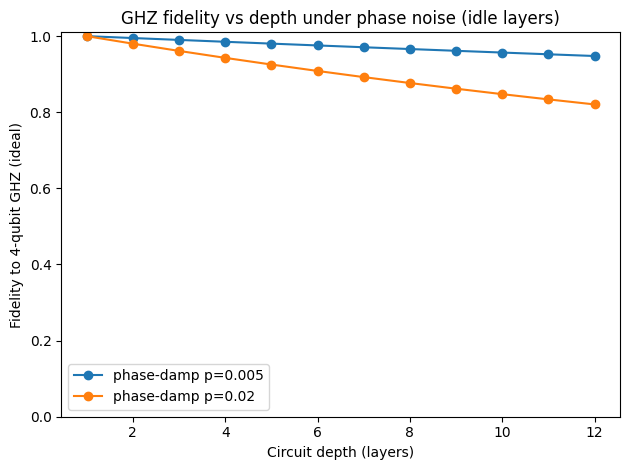

In [5]:
fig, ax = plt.subplots()

for p in [0.005, 0.02]:
    D, F = fidelity_vs_depth(n=4, p_phase=p, max_depth=12)
    ax.plot(D, F, marker='o', label=f"phase-damp p={p}")

ax.set_xlabel("Circuit depth (layers)")
ax.set_ylabel("Fidelity to 4-qubit GHZ (ideal)")
ax.set_ylim(0, 1.01)
ax.set_title("GHZ fidelity vs depth under phase noise (idle layers)")
ax.legend()
fig.tight_layout()

# Save next to the notebook (no folders needed)
fig.savefig("ghz_fidelity.png", dpi=200)
plt.show()




In [6]:
for p in [0.005, 0.02]:
    D, F = fidelity_vs_depth(n=4, p_phase=p, max_depth=12)
    drop = (1 - F[-1]) * 100
    print(f"p={p}: F(start)={F[0]:.4f}, F(end)={F[-1]:.4f}, drop={drop:.2f}%")


p=0.005: F(start)=1.0000, F(end)=0.9478, drop=5.22%
p=0.02: F(start)=1.0000, F(end)=0.8206, drop=17.94%


## Repeats

Repeats controls how many identity operations are in each wait layer, emulating longer per-layer idle time.  


In [7]:
# I add two new controls. Repeats multiply the number of identity operations per layer, emulating longer idle time per layer. 
# Echo inserts Z on even-numbered wait layers. 
# With our noise attachment, Z does not add extra dephasing hits; it only flips phase, which lets us compare echo versus no-echo fairly.
def build_ghz_with_wait(n: int, depth: int, repeats: int = 1, echo: bool = False) -> QuantumCircuit:
    """
    Build a GHZ circuit once, then add (depth-1) idle 'wait' layers.

    Inputs
    n : int
        Number of qubits (>= 2).
    depth : int
        Total layers. Layer 1 prepares GHZ; layers 2..depth are 'wait' layers.
    repeats : int
        Number of identity operations per qubit per wait layer (>=1).
        Larger repeats -> more noise per layer.
    echo : bool
        If True, apply Z to all qubits on every even-numbered wait layer.

    Outputs
    qc : QuantumCircuit
        Circuit implementing GHZ + wait layers (with optional Z echoes).
    """
    if n < 2: raise ValueError("n must be >= 2")
    if depth < 1: raise ValueError("depth must be >= 1")
    if repeats < 1: raise ValueError("repeats must be >= 1")

    qc = QuantumCircuit(n)
    # GHZ preparation
    qc.h(0)
    for j in range(n-1):
        qc.cx(j, j+1)

    # Wait (idle) layers to accrue dephasing noise
    for layer in range(1, depth):
        if echo and (layer % 2 == 0):
            for q in range(n):
                qc.z(q)
        for _ in range(repeats):
            for q in range(n):
                qc.id(q)
        qc.barrier()  # preserve idle structure through transpilation
    return qc


In [8]:
def ghz_fidelity_sweep(
    n: int = 4,
    p_phase: float = 0.02,
    max_depth: int = 12,
    repeats: int = 1,
    echo: bool = False
):
    """
    Sweep circuit depth and compute fidelity to ideal GHZ using build_ghz_with_wait.

    Inputs
    n : int
        Number of qubits (>=2).
    p_phase : float
        Phase-damping probability per gate in [0,1].
    max_depth : int
        Maximum number of layers (>=1).
    repeats : int
        Identity repetitions per wait layer (>=1).
    echo : bool
        If True, insert Z-echo on alternate wait layers.

    Outputs
    depths : np.ndarray
        Array [1, 2, ..., max_depth].
    fidelities : np.ndarray
        Fidelity values in [0,1] relative to the ideal GHZ state (depth=1).

    """
    if n < 2: raise ValueError("n must be >= 2.")
    if not (0 <= p_phase <= 1): raise ValueError("p_phase in [0,1].")
    if max_depth < 1: raise ValueError("max_depth must be >= 1.")
    if repeats < 1: raise ValueError("repeats must be >= 1.")

    noise = make_phase_noise_model(p_phase)
    sim = AerSimulator(method="density_matrix", noise_model=noise)

    # Ideal reference = depth 1 with the same options
    ideal = DensityMatrix(
        Statevector.from_label('0'*n).evolve(
            build_ghz_with_wait(n, 1, repeats=repeats, echo=echo)
        )
    )

    depths = np.arange(1, max_depth+1, dtype=int)
    fidelities = []
    for d in depths:
        qc = build_ghz_with_wait(n, d, repeats=repeats, echo=echo)
        qc.save_density_matrix()
        tqc = transpile(qc, sim, optimization_level=0)
        result = sim.run(tqc, shots=1).result()
        rho = result.data(0)['density_matrix']
        fidelities.append(state_fidelity(rho, ideal))

    return depths, np.asarray(fidelities, dtype=float)


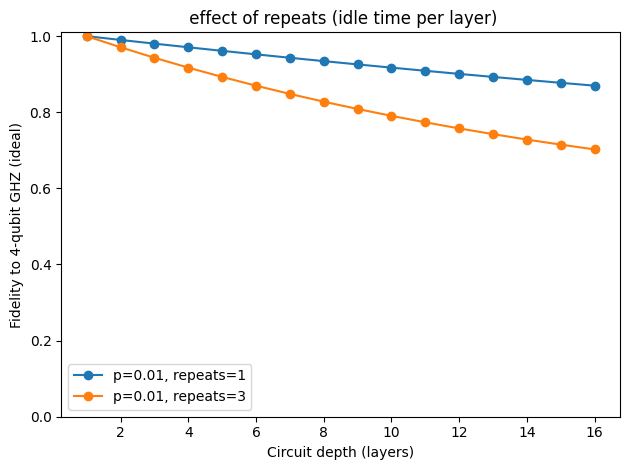

In [9]:
fig, ax = plt.subplots()
for rep in [1, 3]:
    D, F = ghz_fidelity_sweep(n=4, p_phase=0.01, max_depth=16, repeats=rep, echo=False)
    ax.plot(D, F, marker='o', label=f"p=0.01, repeats={rep}")

ax.set_xlabel("Circuit depth (layers)")
ax.set_ylabel("Fidelity to 4-qubit GHZ (ideal)")
ax.set_ylim(0, 1.01)
ax.set_title(" effect of repeats (idle time per layer)")
ax.legend()
fig.tight_layout()
fig.savefig("ghz_fidelity_repeats.png", dpi=200)
plt.show()



## Extra runs for p = 0.005 and p = 0.02

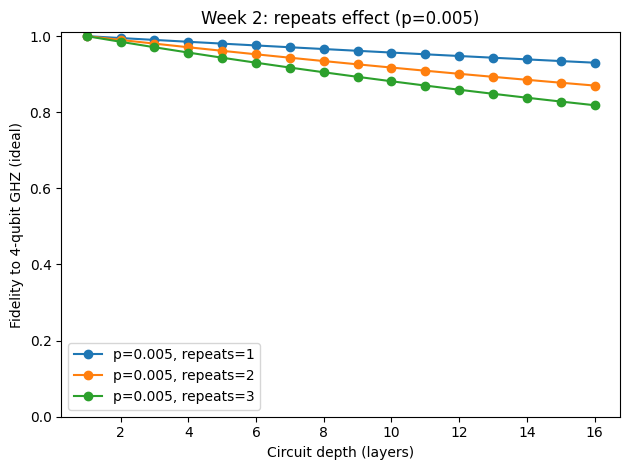

In [10]:
p = 0.005
fig, ax = plt.subplots()
for rep in [1, 2, 3]:
    D, F = ghz_fidelity_sweep(n=4, p_phase=p, max_depth=16, repeats=rep, echo=False)
    ax.plot(D, F, marker='o', label=f"p={p}, repeats={rep}")
ax.set_xlabel("Circuit depth (layers)")
ax.set_ylabel("Fidelity to 4-qubit GHZ (ideal)")
ax.set_ylim(0, 1.01)
ax.set_title("Week 2: repeats effect (p=0.005)")
ax.legend()
fig.tight_layout()
fig.savefig("ghz_fidelity_repeats_p0005.png", dpi=200)
plt.show()


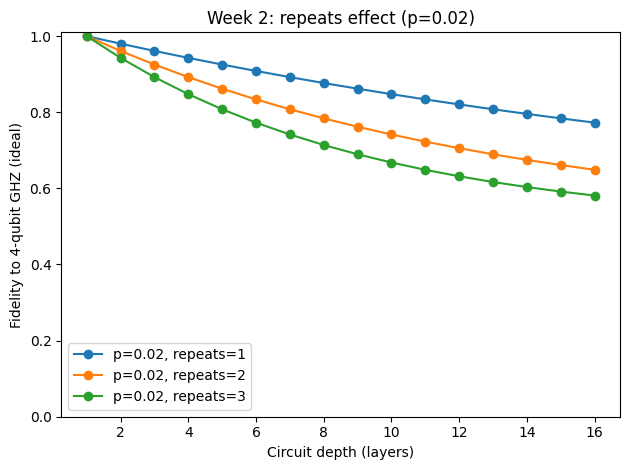

In [11]:
p = 0.02
fig, ax = plt.subplots()
for rep in [1, 2, 3]:
    D, F = ghz_fidelity_sweep(n=4, p_phase=p, max_depth=16, repeats=rep, echo=False)
    ax.plot(D, F, marker='o', label=f"p={p}, repeats={rep}")
ax.set_xlabel("Circuit depth (layers)")
ax.set_ylabel("Fidelity to 4-qubit GHZ (ideal)")
ax.set_ylim(0, 1.01)
ax.set_title("Week 2: repeats effect (p=0.02)")
ax.legend()
fig.tight_layout()
fig.savefig("ghz_fidelity_repeats_p0020.png", dpi=200)
plt.show()


# GHZ size comparison (n = 3, 4, 5)

I compare fidelity vs depth for different GHZ sizes under the same phase noise.  
Expectation: larger GHZ (more qubits) loses global coherence faster.



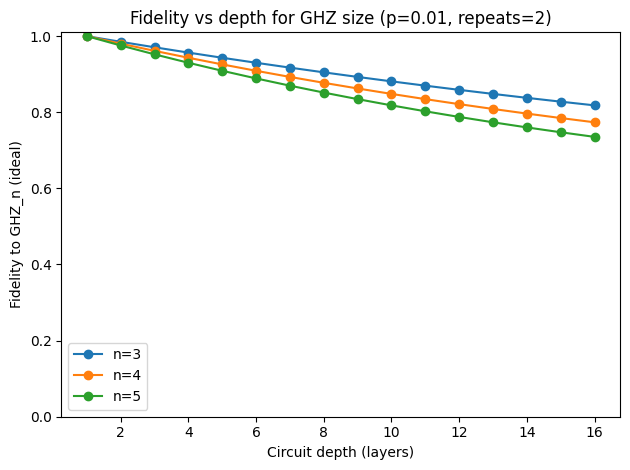

In [12]:
# GHZ size comparison
p = 0.01
max_depth = 16
sizes = [3, 4, 5]
repeats = 2

fig, ax = plt.subplots()
for n in sizes:
    D, F = ghz_fidelity_sweep(n=n, p_phase=p, max_depth=max_depth, repeats=2, echo=False)
    ax.plot(D, F, marker='o', label=f"n={n}")
ax.set_xlabel("Circuit depth (layers)")
ax.set_ylabel("Fidelity to GHZ_n (ideal)")
ax.set_ylim(0, 1.01)
ax.set_title(f"Fidelity vs depth for GHZ size (p={p}, repeats=2)")
ax.legend()
fig.tight_layout()
fig.savefig("ghz_size_comparison.png", dpi=200)
plt.show()


In [13]:
# Run sweeps once
series = {}
for n in sizes:
    D, F = ghz_fidelity_sweep(n=n, p_phase=p, max_depth=max_depth, repeats=repeats, echo=False)
    series[n] = F

# Print header
print("depth," + ",".join([f"F_n{n}" for n in sizes]))

# Print rows
for i, d in enumerate(range(1, max_depth + 1)):
    row = [str(d)] + [f"{series[n][i]:.8f}" for n in sizes]
    print(",".join(row))


depth,F_n3,F_n4,F_n5
1,1.00000000,1.00000000,1.00000000
2,0.98514950,0.98029801,0.97549503
3,0.97074008,0.96137235,0.95219104
4,0.95675863,0.94319244,0.93002918
5,0.94319244,0.92572889,0.90895347
6,0.93002918,0.90895347,0.88891068
7,0.91725689,0.89283908,0.86985019
8,0.90486394,0.87735965,0.85172385
9,0.89283908,0.86249017,0.83448589
10,0.88117136,0.84820661,0.81809275
11,0.86985019,0.83448589,0.80250304
12,0.85886527,0.82130581,0.78767738
13,0.84820661,0.80864508,0.77357833
14,0.83786453,0.79648323,0.76017027
15,0.82782962,0.78480061,0.74741934
16,0.81809275,0.77357833,0.73529333


## A diagram for the circuit and setup

In [14]:
# Logical circuit 
n, depth, repeats = 4, 6, 2

qc_no = build_ghz_with_wait(n=n, depth=depth, repeats=repeats, echo=False)
qc_ec = build_ghz_with_wait(n=n, depth=depth, repeats=repeats, echo=True)

print("Logical circuit — no echo")
print(qc_no.draw(output="text"))

print("\nLogical circuit — with echo (Z on even wait layers)")
print(qc_ec.draw(output="text"))


Logical circuit — no echo
     ┌───┐     ┌───┐┌───┐           ░ ┌───┐┌───┐ ░ ┌───┐┌───┐ ░ ┌───┐┌───┐ ░ »
q_0: ┤ H ├──■──┤ I ├┤ I ├───────────░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─»
     └───┘┌─┴─┐└───┘├───┤┌───┐      ░ ├───┤├───┤ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ »
q_1: ─────┤ X ├──■──┤ I ├┤ I ├──────░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─»
          └───┘┌─┴─┐└───┘├───┤┌───┐ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ »
q_2: ──────────┤ X ├──■──┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─»
               └───┘┌─┴─┐├───┤├───┤ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ ├───┤├───┤ ░ »
q_3: ───────────────┤ X ├┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─┤ I ├┤ I ├─░─»
                    └───┘└───┘└───┘ ░ └───┘└───┘ ░ └───┘└───┘ ░ └───┘└───┘ ░ »
«     ┌───┐┌───┐ ░ 
«q_0: ┤ I ├┤ I ├─░─
«     ├───┤├───┤ ░ 
«q_1: ┤ I ├┤ I ├─░─
«     ├───┤├───┤ ░ 
«q_2: ┤ I ├┤ I ├─░─
«     ├───┤├───┤ ░ 
«q_3: ┤ I ├┤ I ├─░─
«     └───┘└───┘ ░ 

Logical circuit — with echo (Z on even wait layers)
     ┌───┐     ┌───┐┌───┐     

## Logarithmic Negativity 

In [15]:
def build_rho_ghz_dephased(n, gamma):
    """
    Construct an n-qubit GHZ density matrix whose GHZ-subspace coherence is scaled by `gamma`.

    State:
        rho = 1/2(|0...0><0...0| + |1...1><1...1|)
              + 1/2 * gamma (|0...0><1...1| + |1...1><0...0|)

    Inputs
    ------
    n : int
        Number of qubits.
    gamma : float
        Coherence factor in [0, 1] multiplying the GHZ off-diagonal terms.

    Outputs
    -------
    np.ndarray
        Density matrix of shape (2**n, 2**n), dtype complex.
    """
    dim = 2**n
    rho = np.zeros((dim, dim), dtype=complex)
    rho[0, 0] = 0.5
    rho[-1, -1] = 0.5
    rho[0, -1] = 0.5 * gamma
    rho[-1, 0] = 0.5 * gamma
    return rho


def _partial_transpose_A0(rho, n):
    """
    Take the partial transpose of `rho` with respect to qubit 0 (the 1 | (N-1) split).

    Inputs
    ------
    rho : np.ndarray
        Density matrix of shape (2**n, 2**n).
    n : int
        Number of qubits.

    Outputs
    -------
    np.ndarray
        The partially transposed matrix rho^{T_A} with the same shape as `rho`.
    """
    dims = [2] * n
    reshaped = rho.reshape(*(dims + dims))  # ket [0..n-1], bra [n..2n-1]
    reshaped = np.swapaxes(reshaped, 0, n + 0)
    return reshaped.reshape(rho.shape)


def log_negativity_A0(rho, n):
    """
    Compute log-negativity across the 1 | (N-1) bipartition (A = {0}).

    Definition:
        E_N = log2( || rho^{T_A} ||_1 ), with the trace norm computed via SVD.

    Inputs
    ------
    rho : np.ndarray
        Density matrix of shape (2**n, 2**n).
    n : int
        Number of qubits.

    Outputs
    -------
    float
        Log-negativity (in bits).
    """
    rho_PT = _partial_transpose_A0(rho, n)
    svals = np.linalg.svd(rho_PT, compute_uv=False)
    return float(np.log2(svals.sum()))


def compute_log_negativity_curve(n, depths, repeats, p_phase):
    """
    Compute log-negativity vs depth for GHZ under wait-only Markovian dephasing (A={0}).

    Uses c = sqrt(1 - p_phase) and gamma(d) = c^(n * repeats * (d-1)).
    For each depth d, builds a GHZ-subspace density matrix with coherence gamma(d)
    and evaluates the log-negativity.

    Inputs
    ------
    n : int
        Number of qubits.
    depths : int or 1D array-like of int
        Circuit depths (>= 1). Depth=1 means no wait layers.
    repeats : int
        Identity gates per qubit per wait layer.
    p_phase : float
        Phase-damping Kraus parameter per wait gate (0 <= p_phase <= 1).

    Outputs
    -------
    np.ndarray
        Log-negativity values for each depth, same shape as `depths`.
    """
    d = np.asarray(depths, dtype=int)
    c = np.sqrt(1.0 - p_phase)
    gammas = np.power(c, n * repeats * (d - 1))
    EN = np.empty_like(gammas, dtype=float)
    for i, g in enumerate(gammas):
        rho = build_rho_ghz_dephased(n, float(g))
        EN[i] = log_negativity_A0(rho, n)
    return EN



def plot_logneg_multi(depths, n_values, repeats, p_phase):
    """
    Plot log-negativity (A={0}) for several `n` values on one figure.

    Inputs
    ------
    depths : int or 1D array-like of int
        Circuit depths (>= 1).
    n_values : list of int
        Qubit counts to plot, e.g., [3, 4, 5].
    repeats : int
        Identity gates per qubit per wait layer.
    p_phase : float
        Phase-damping Kraus parameter per wait gate.

    Outputs
    -------
    None
        Displays the matplotlib figure.
    """
    d = np.asarray(depths, dtype=int)
    for n in n_values:
        EN = compute_log_negativity_curve(n, d, repeats, p_phase)
        plt.plot(d, EN, 'o-', label=f'n={n}')
    plt.xlabel('Circuit depth $d$')
    plt.ylabel('Log-negativity $\\mathcal{E}_N(1\\,|\\,N-1)$')
    plt.title('Log-negativity vs Depth')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_log_negativity_vs_depth(depths, EN, n=None, p_phase=None, title=None):
    """
    Plot log-negativity vs circuit depth for the $1\,|\,(N-1)$ bipartition.

    Inputs
    depths : int or 1D array-like of int
        Circuit depths (>= 1). Depth = 1 means no wait layers.
    EN : array-like of float
        Log-negativity values corresponding to `depths`.
    n : int, optional
        Number of qubits (used only to annotate the title).
    p_phase : float, optional
        Per-wait phase-damping probability (used only to annotate the title).
    title : str, optional
        Custom figure title. If omitted, a title is generated as:
        "Log-negativity vs Depth (n=..., $p_{\\text{phase}}$=...)".

    Outputs
        Displays a Matplotlib figure of $\\mathcal{E}_N(1\,|\,N-1)$ versus depth.

    """
    plt.figure()
    plt.plot(depths, EN, 'o-')
    plt.xlabel('Circuit depth $d$')
    plt.ylabel('Log-negativity $\\mathcal{E}_N\\;(1\\,|\\,N-1)$')
    if title is None:
        extras = []
        if n is not None:
            extras.append(f"n={n}")
        if p_phase is not None:
            extras.append(f"$p_\\text{{phase}}$={p_phase}")
        title = "Log-negativity vs Depth" + (f" ({', '.join(extras)})" if extras else "")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


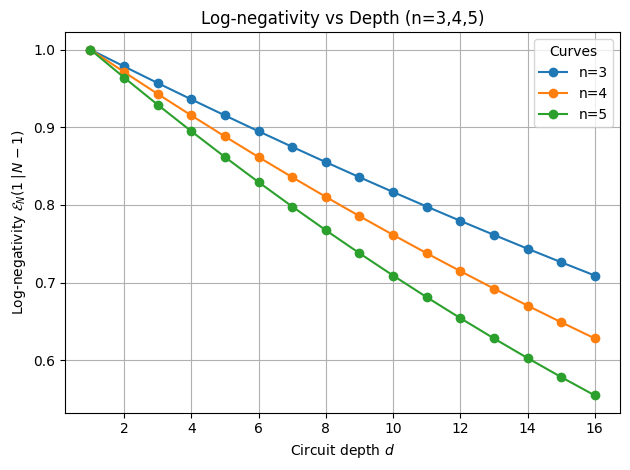

depth,EN_n3,EN_n4,EN_n5
1,1.00000000,1.00000000,1.00000000
2,0.97830584,0.97114805,0.96402705
3,0.95694282,0.94288466,0.92897346
4,0.93591070,0.91520910,0.89483750
5,0.91520910,0.88812018,0.86161623
6,0.89483750,0.86161623,0.82930559
7,0.87479521,0.83569510,0.79790041
8,0.85508140,0.81035421,0.76739439
9,0.83569510,0.78559049,0.73778017
10,0.81663519,0.76140046,0.70904938
11,0.79790041,0.73778017,0.68119262
12,0.77948935,0.71472530,0.65419958
13,0.76140046,0.69223108,0.62805902
14,0.74363206,0.67029237,0.60275887
15,0.72618235,0.64890364,0.57828627
16,0.70904938,0.62805902,0.55462761


In [17]:
# Parameters
n_values = [3, 4, 5]
p_phase = 0.02
max_depth = 16
repeats = 1
depths = np.arange(1, max_depth + 1, dtype=int)

# Compute once per n
EN_series = {n: compute_log_negativity_curve(n, depths, repeats, p_phase) for n in n_values}

# Plot
plt.figure()
for n in n_values:
    EN_vals = EN_series[n]
    plt.plot(depths, EN_vals, 'o-', label=f'n={n}')
plt.xlabel('Circuit depth $d$')
plt.ylabel('Log-negativity $\\mathcal{E}_N(1\\,|\\,N-1)$')
plt.title('Log-negativity vs Depth (n=3,4,5)')
plt.legend(title='Curves')
plt.grid(True)
plt.tight_layout()
fig.savefig("ghz_log_negativity.png", dpi=200)
plt.show()

# Numbers
header = "depth," + ",".join([f"EN_n{n}" for n in n_values])
print(header)
for i, d in enumerate(depths):
    row = [str(d)] + [f"{EN_series[n][i]:.8f}" for n in n_values]
    print(",".join(row))

## Numeric vs analytic fidelity check

Here I compare the Qiskit density-matrix simulation of GHZ dephasing to the
closed-form analytic model from the theory section.

For a GHZ state under memoryless phase damping with parameter $(p_{\text{phase}})$,
each single-qubit dephasing hit multiplies the GHZ coherence by
$(c = \sqrt{1 - p_{\text{phase}}})$. In the idle-only circuit used here, the
$(|0\ldots0\rangle\langle 1\ldots1|)$ element picks up

$[
\gamma(d) = c^{n\,r\,(d-1)}
]$

where \(n\) is the number of qubits, \(r\) is `repeats` (number of identity
gates per qubit per wait layer), and \(d\) is the total depth (first layer
prepares GHZ). For this model, the analytic fidelity is

$[
F(d) = \frac{1 + \gamma(d)}{2}.
]$

Below I overlay the numeric (Qiskit) fidelity data with the analytic curve
for several values of \(n\).


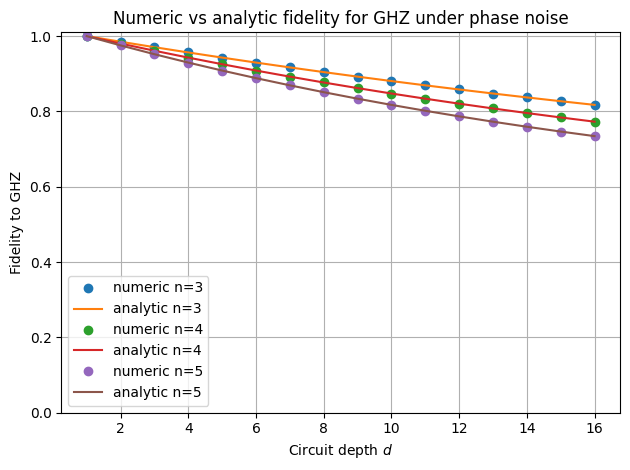

In [18]:
# Helper: analytic GHZ coherence and fidelity under phase damping.
# Uses the same gamma(d) = c^{n * repeats * (d-1)} model as in the report.

def analytic_gamma_ghz(
    depths: np.ndarray,
    n: int,
    p_phase: float,
    repeats: int = 1
) -> np.ndarray:
    """
    Analytic coherence factor gamma(d) for n-qubit GHZ under phase damping.

    Inputs
    depths : np.ndarray
        Array of integer depths d >= 1.
    n : int
        Number of qubits (>=2).
    p_phase : float
        Phase-damping probability per single-qubit gate in [0,1].
    repeats : int
        Number of identity operations per qubit per wait layer (>=1).

    Outputs
    gamma : np.ndarray
        Coherence factor gamma(d) in [0,1] for each depth.
    """
    d = np.asarray(depths, dtype=float)
    if not (0 <= p_phase <= 1):
        raise ValueError("p_phase must be in [0,1].")
    if n < 2:
        raise ValueError("n must be >= 2.")
    if repeats < 1:
        raise ValueError("repeats must be >= 1.")

    # c is the single-qubit coherence factor per phase-damping hit.
    c = np.sqrt(1.0 - p_phase)

    # GHZ coherence |0...0><1...1| crosses every qubit in every idle hit.
    exponent = n * repeats * (d - 1.0)
    gamma = c ** exponent
    return gamma


def analytic_fidelity_ghz(
    depths: np.ndarray,
    n: int,
    p_phase: float,
    repeats: int = 1
) -> np.ndarray:
    """
    Analytic fidelity F(d) between decohered GHZ and ideal GHZ.

    Inputs
    depths : np.ndarray
        Array of integer depths d >= 1.
    n : int
        Number of qubits (>=2).
    p_phase : float
        Phase-damping probability per single-qubit gate in [0,1].
    repeats : int
        Number of identity operations per qubit per wait layer (>=1).

    Outputs
    F : np.ndarray
        Fidelity values F(d) in [0,1].
    """
    gamma = analytic_gamma_ghz(depths, n=n, p_phase=p_phase, repeats=repeats)
    F = 0.5 * (1.0 + gamma)
    return F


# Overlay numeric vs analytic fidelity for n = 3, 4, 5 at a fixed p_phase.

p_phase = 0.02
max_depth = 16
repeats = 1
sizes = [3, 4, 5]

fig, ax = plt.subplots()

for n in sizes:
    # Numeric fidelity from the Qiskit simulation
    depths, F_num = ghz_fidelity_sweep(
        n=n,
        p_phase=p_phase,
        max_depth=max_depth,
        repeats=repeats,

    )

    # Analytic fidelity using the closed-form formula
    F_th = analytic_fidelity_ghz(depths, n=n, p_phase=p_phase, repeats=repeats)

    ax.plot(depths, F_num, 'o', label=f"numeric n={n}")
    ax.plot(depths, F_th, '-', label=f"analytic n={n}")

ax.set_xlabel("Circuit depth $d$")
ax.set_ylabel("Fidelity to GHZ")
ax.set_ylim(0, 1.01)
ax.set_title("Numeric vs analytic fidelity for GHZ under phase noise")
ax.grid(True)
ax.legend()
fig.tight_layout()
fig.savefig("ghz_fidelity_numeric_vs_analytic_scaling.png", dpi=200)
plt.show()


##  Mapping depth to physical time and T₂

So far, depth is a discrete proxy for idle time. To connect to device parameters,
I now interpret each idle layer as a fixed time step $(\Delta t)$, and relate
the phase-damping probability $(p_{\text{phase}})$ to a physical $(T_2)$.

For a single qubit with pure dephasing time $(T_2)$ and time step $(\Delta t)$,

$[
c = e^{-\Delta t / T_2}, \qquad
\lambda = 1 - c^2 = 1 - e^{-2 \Delta t / T_2},
]$

and Qiskit's `phase_damping_error(λ)` implements this channel. For the
n-qubit GHZ coherence under the same idle-only circuit,

$[
\gamma(t) = e^{-N t / T_2}, \quad t = (d-1)\,r\,\Delta t.
]$

Below I pick a sample $(T_2)$ and $(\Delta t)$, derive the implied `p_phase`,
and plot the numeric and analytic fidelity as a function of physical time.


Derived p_phase = 0.181269 for T2 = 50.0 µs, Δt = 5.0 µs


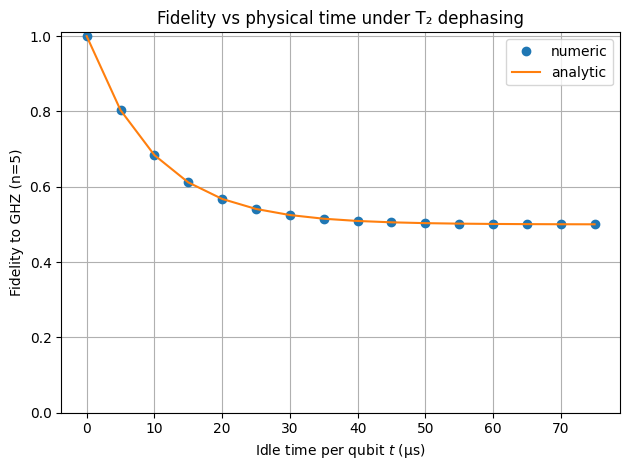

Approx half-coherence for n=5: t ≈ 5.00 µs, F ≈ 0.803


In [19]:
def p_phase_from_T2(delta_t: float, T2: float) -> float:
    """
    Compute the phase-damping probability p_phase from T2 and Δt.

    Inputs
    delta_t : float
        Idle time per layer per qubit (seconds).
    T2 : float
        Pure dephasing time T2 (seconds).

    Outputs
    p_phase : float
        Phase-damping probability for phase_damping_error in [0,1].
    """
    if delta_t <= 0:
        raise ValueError("delta_t must be > 0.")
    if T2 <= 0:
        raise ValueError("T2 must be > 0.")

    c = np.exp(-delta_t / T2)      # single-qubit coherence per step
    p_phase = 1.0 - c**2           # Qiskit λ parameter
    return p_phase


def depth_to_time(depths: np.ndarray, repeats: int, delta_t: float) -> np.ndarray:
    """
    Map circuit depths to total idle time per qubit.

    Inputs
    depths : np.ndarray
        Integer depths d >= 1.
    repeats : int
        Number of idle identity gates per qubit per wait layer.
    delta_t : float
        Idle time per single identity operation (seconds).

    Outputs
    t : np.ndarray
        Total idle time per qubit (seconds) for each depth.
    """
    if repeats < 1:
        raise ValueError("repeats must be >= 1.")
    if delta_t <= 0:
        raise ValueError("delta_t must be > 0.")

    d = np.asarray(depths, dtype=float)
    t = (d - 1.0) * repeats * delta_t
    return t


# Example: pick a plausible T2 and Δt, plot F(t) for n=5.

T2 = 50e-6       # 50 microseconds
delta_t = 5e-6   # 5 microseconds per idle layer per qubit
n = 5
max_depth = 16
repeats = 1

p_phase_T2 = p_phase_from_T2(delta_t=delta_t, T2=T2)
print(f"Derived p_phase = {p_phase_T2:.6f} for T2 = {T2*1e6:.1f} µs, Δt = {delta_t*1e6:.1f} µs")

# Numeric fidelity vs depth from Qiskit
depths, F_num = ghz_fidelity_sweep(
    n=n,
    p_phase=p_phase_T2,
    max_depth=max_depth,
    repeats=repeats,
)

# Convert depths to physical time t
t = depth_to_time(depths, repeats=repeats, delta_t=delta_t)

# Analytic coherence and fidelity vs time
gamma_t = np.exp(-n * t / T2)
F_th = 0.5 * (1.0 + gamma_t)

# Plot numeric vs analytic as a function of time
fig, ax = plt.subplots()
ax.plot(t * 1e6, F_num, 'o', label="numeric")
ax.plot(t * 1e6, F_th, '-', label="analytic")
ax.set_xlabel("Idle time per qubit $t$ (µs)")
ax.set_ylabel("Fidelity to GHZ (n=5)")
ax.set_ylim(0, 1.01)
ax.set_title("Fidelity vs physical time under T₂ dephasing")
ax.grid(True)
ax.legend()
fig.tight_layout()
fig.savefig("ghz_fidelity_vs_time_T2.png", dpi=200)
plt.show()

# Rough "half-coherence" time: F = (1 + γ)/2, so γ = 1/2 corresponds to F = 0.75
idx_half = np.argmin(np.abs(F_th - 0.75))
print(f"Approx half-coherence for n={n}: t ≈ {t[idx_half]*1e6:.2f} µs, F ≈ {F_th[idx_half]:.3f}")


## Log-negativity vs physical time

For the analytic GHZ dephasing model under pure phase damping, the
logarithmic negativity across the \(1 | (n-1)\) bipartition depends only on
the coherence factor \(\gamma(t)\). For the idle-only circuit and T\(_2\)
model used above,

$[
\gamma(t) = e^{-N t / T_2},
]$

and the log-negativity is

$[
\mathcal{E}_N(t) = \log_2\bigl(1 + |\gamma(t)|\bigr).
]$

Below I use the same $(\gamma(t))$ as in the fidelity plot and show
$(\mathcal{E}_N)$ as a function of physical idle time per qubit.


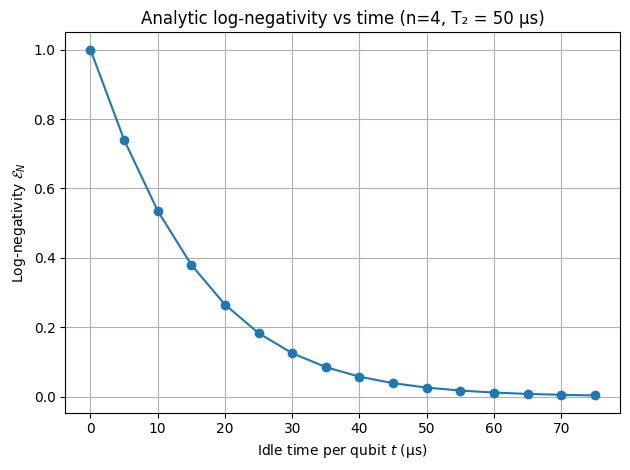

In [22]:
# Recompute gamma(t).
def analytic_log_neg_from_gamma(gamma: np.ndarray) -> np.ndarray:
    """
    Compute log-negativity E_N for the GHZ dephasing model from gamma.

    Inputs
    gamma : np.ndarray
        Coherence factor(s) gamma(t) in [0,1] for the GHZ off-diagonal term.

    Outputs
    EN : np.ndarray
        Log-negativity values E_N(t) = log2(1 + |gamma|).
    """
    gamma = np.asarray(gamma, dtype=float)
    EN = np.log2(1.0 + np.abs(gamma))
    return EN
gamma_t = np.exp(-n * t / T2)
EN_th = analytic_log_neg_from_gamma(gamma_t)

fig, ax = plt.subplots()
ax.plot(t * 1e6, EN_th, '-o')
ax.set_xlabel("Idle time per qubit $t$ (µs)")
ax.set_ylabel("Log-negativity $\\mathcal{E}_N$")
ax.set_title(f"Analytic log-negativity vs time (n={n}, T₂ = {T2*1e6:.0f} µs)")
ax.grid(True)
fig.tight_layout()
fig.savefig("ghz_logneg_vs_time_T2.png", dpi=200)
plt.show()

## Comparing different Markovian noise channels

To see how different Markovian channels affect GHZ robustness, I repeat the
idle-only GHZ experiment with:

- Phase damping (pure dephasing, as before),
- Amplitude damping (energy relaxation),
- Single-qubit depolarising noise.

All channels are attached to `id` gates on every qubit. I then compare the
fidelity curves \(F(d)\) for each channel at the same nominal error probability
to illustrate the qualitative differences in how they destroy GHZ coherence.


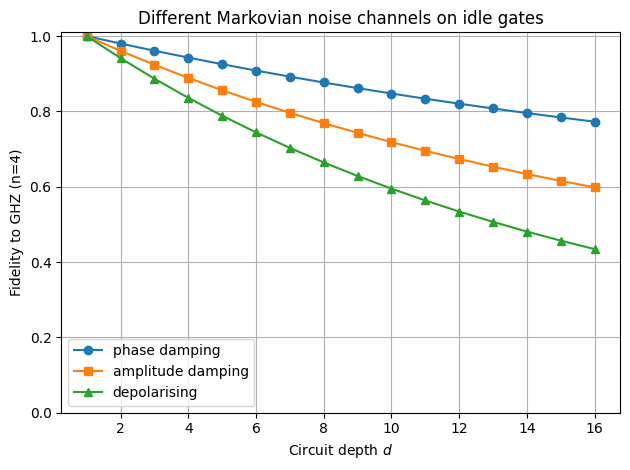

In [25]:
# Extra imports for additional noise channels.
from qiskit_aer.noise import amplitude_damping_error, depolarizing_error

def make_amplitude_noise_model(p_amp: float) -> NoiseModel:
    """
    Amplitude-damping noise model on idle gates.

    Inputs
    p_amp : float in [0,1]
        Amplitude-damping probability per single-qubit 'id' gate.

    Outputs
    noise_model : NoiseModel
        Noise model with amplitude damping attached to 1q id gates.
    """
    if not (0 <= p_amp <= 1):
        raise ValueError("p_amp must be in [0,1].")

    noise_model = NoiseModel()
    err = amplitude_damping_error(p_amp)
    noise_model.add_all_qubit_quantum_error(err, ['id'])
    return noise_model


def make_depolarising_noise_model(p_dep: float) -> NoiseModel:
    """
    Depolarising noise model on idle gates.

    Inputs
    p_dep : float in [0,1]
        Depolarising probability per single-qubit 'id' gate.

    Outputs
    noise_model : NoiseModel
        Noise model with single-qubit depolarising noise on id gates.
    """
    if not (0 <= p_dep <= 1):
        raise ValueError("p_dep must be in [0,1].")

    noise_model = NoiseModel()
    err = depolarizing_error(p_dep, 1)
    noise_model.add_all_qubit_quantum_error(err, ['id'])
    return noise_model


def fidelity_vs_depth_with_noise_model(
    n: int,
    max_depth: int,
    repeats: int,
    noise_model: NoiseModel
):
    """
    Compute GHZ fidelity vs depth using an arbitrary 1q noise model on id gates.

    Inputs
    n : int
        Number of qubits (>=2).
    max_depth : int
        Maximum circuit depth d (>=1).
    repeats : int
        Number of identity operations per qubit per wait layer.
    echo : bool
        Whether to insert Z echoes on even wait layers (passed to build_ghz_with_wait).
    noise_model : NoiseModel
        Qiskit noise model applied to the simulator.

    Outputs
    depths : np.ndarray
        Integer depths from 1..max_depth.
    fidelities : np.ndarray
        Fidelity values to the ideal GHZ state for each depth.
    """
    if n < 2:
        raise ValueError("n must be >= 2.")
    if max_depth < 1:
        raise ValueError("max_depth must be >= 1.")

    sim = AerSimulator(method="density_matrix", noise_model=noise_model)

    # Ideal GHZ reference at depth = 1 (no additional wait layers).
    qc_ideal = build_ghz_with_wait(n, depth=1, repeats=repeats, echo=False)
    ideal_dm = DensityMatrix.from_instruction(qc_ideal)

    depths = np.arange(1, max_depth+1, dtype=int)
    fidelities = []

    for d in depths:
        qc = build_ghz_with_wait(n, depth=d, repeats=repeats)
        qc.save_density_matrix()
        tqc = transpile(qc, sim, optimization_level=0)
        result = sim.run(tqc, shots=1).result()
        rho = result.data(0)['density_matrix']
        fidelities.append(state_fidelity(rho, ideal_dm))

    return depths, np.asarray(fidelities, dtype=float)


# Compare phase damping, amplitude damping, and depolarising noise.

n = 4
max_depth = 16
repeats = 1

p = 0.02  # use the same nominal error probability for all three channels

noise_phase = make_phase_noise_model(p)
noise_amp = make_amplitude_noise_model(p)
noise_dep = make_depolarising_noise_model(p)

D_phase, F_phase = fidelity_vs_depth_with_noise_model(
    n=n, max_depth=max_depth, repeats=repeats, noise_model=noise_phase
)
_, F_amp = fidelity_vs_depth_with_noise_model(
    n=n, max_depth=max_depth, repeats=repeats, noise_model=noise_amp
)
_, F_dep = fidelity_vs_depth_with_noise_model(
    n=n, max_depth=max_depth, repeats=repeats, noise_model=noise_dep
)

plt.figure()
plt.plot(D_phase, F_phase, 'o-', label="phase damping")
plt.plot(D_phase, F_amp, 's-', label="amplitude damping")
plt.plot(D_phase, F_dep, '^-', label="depolarising")
plt.xlabel("Circuit depth $d$")
plt.ylabel("Fidelity to GHZ (n=4)")
plt.ylim(0, 1.01)
plt.title("Different Markovian noise channels on idle gates")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("ghz_fidelity_noise_comparison.png", dpi=200)
plt.show()
